# Self-Driving Car Engineer Nanodegree


## Project: **Basic Lane Detection** 
***
In this project, OpenCV is used to identify lane lines on the road. The pipeline is developed on a series of individual images and later applied to a video stream. The applied OpenCV tools are color selection, a region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection, and Hough Transform line detection. Here, the goal is to piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display.


<p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> The goal is to detect/connect/average/extrapolate line segments to get results like this</p> 
 </figcaption>
</figure>

## Import Packages

In [1]:
%matplotlib inline
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2 

## Read in an Image

Image dimensions: (540, 960, 3)


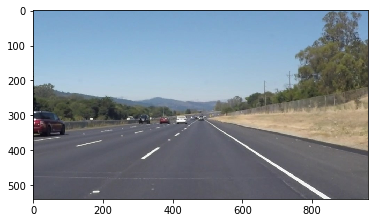

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('Image dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Helper Functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img


# Python 3 has support for cool math symbols.
#initial_img, α=0.8, β=1., λ=0.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):

    return cv2.addWeighted(initial_img, α, img, β, λ)

In [4]:
def draw_lines(img, lines, color=[255, 0, 0 ], thickness=10):
    """
    Connect/average/extrapolate line segments
    
    """
    
    slopes = []
    positive_slope_lines = []
    negative_slope_lines = []
    slope_threshold = 0.5
    imshape =  img.shape
    
    # Calculate slope
    slopes = (lines[:,:,3] - lines[:,:,1])/ (lines[:,:,2] - lines[:,:,0])
    
    i,j = np.where(slopes > slope_threshold)
    positive_slope_lines = lines[ i ]
    
    i,j = np.where(slopes < -1 * slope_threshold)
    negative_slope_lines = lines[ i ]
    
       
    positive_slope_lines = np.reshape(positive_slope_lines,(-1,2))
    negative_slope_lines = np.reshape(negative_slope_lines,(-1,2))
    
    if (positive_slope_lines.size != 0):
        m_pos, b_pos = np.polyfit(positive_slope_lines[:,0], positive_slope_lines[:,1], 1)
        y1_pos = imshape[1] 
        x1_pos = int((y1_pos - b_pos) / m_pos)
        y2_pos = int(imshape[1] * .35)
        x2_pos = int((y2_pos - b_pos) / m_pos)
        cv2.line(img, (x1_pos, y1_pos), (x2_pos, y2_pos), color, thickness)
        
        
    if (negative_slope_lines.size != 0):
        m_neg, b_neg = np.polyfit(negative_slope_lines[:,0], negative_slope_lines[:,1], 1)
        y1_neg = imshape[0] 
        x1_neg = int((y1_neg - b_neg) / m_neg)
        y2_neg = int(imshape[1] * .35)
        x2_neg = int((y2_neg - b_neg) / m_neg)
        cv2.line(img, (x1_neg, y1_neg), (x2_neg, y2_neg), color, thickness)    


def filter_color(img):
    """Applies a yellow and white filter"""
    # Convert to HLS format
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

    # yellow color 
    lower = np.uint8([20, 120, 80])
    upper = np.uint8([45, 200, 255])
    yellow_mask = cv2.inRange(hls, lower, upper)

    # white color 
    RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    lower = np.uint8([200, 200, 200])
    upper = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(RGB, lower, upper)

    # combine the mask
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    result = cv2.bitwise_and(img, img, mask=mask)
    return result


## Test Images

In [5]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline

In [6]:
image_source_path = "test_images/"
image_ouput_path = "test_images_output/"
kernel_size = 5
low_threshold = 50
high_threashold = 150

rho = 1 
theta = np.pi/180
threshold = 10
min_line_length = 10
max_line_gap = 50
number_of_pass = 1

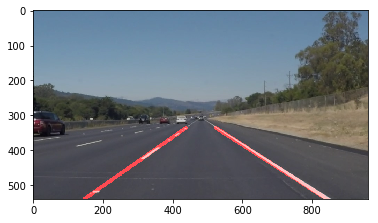

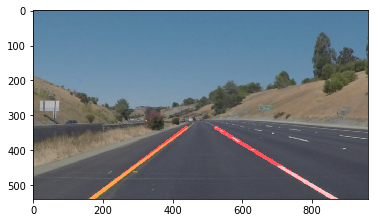

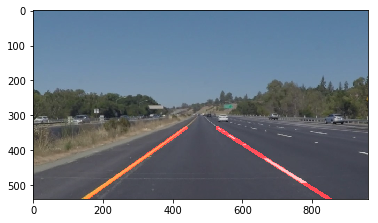

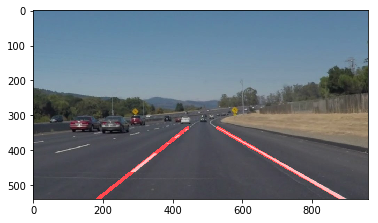

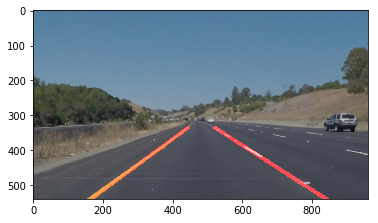

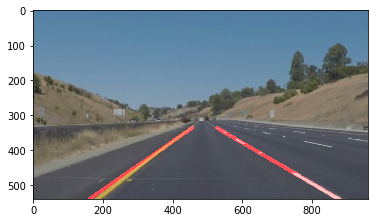

In [7]:
fig_index=0

for imgName in os.listdir(image_source_path):
    img_org = mpimg.imread(image_source_path + imgName)  
    imshape =  img_org.shape
    img = np.copy(img_org)
    filtered = filter_color (img)
    blured_filtered = gaussian_blur (img, kernel_size)    
     
  
    
    edges = canny (blured_filtered, low_threshold, high_threashold)
    
    # print(imshape)
    vertices = np.array([[
                        (100,imshape[0]),
                        (400, 330), 
                        (800, 330), 
                        (imshape[1],imshape[0])
                                    ]], dtype=np.int32)
    masked = region_of_interest(edges, vertices)
    line_image = hough_lines (masked, rho, theta, threshold,min_line_length, max_line_gap)
    final_img = weighted_img(line_image,img_org)
    
    plt.figure(fig_index+1)
    plt.imshow(final_img)
    fig_index+=1
    # Save the results
    brg_image = cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)
    cv2.imwrite ( image_ouput_path+ imgName, brg_image)
   
   

## Test on Videos


**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [8]:
# Import librariesto edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import imageio
imageio.plugins.ffmpeg.download()

In [9]:
def process_image(image):
    blured = gaussian_blur (image, kernel_size)
    blured_filtered = filter_color(blured)
    grayed = grayscale (blured_filtered)
    edges = canny (grayed, low_threshold, high_threashold)   
    imshape =  image.shape

    vertices = np.array([[
                        (100,imshape[0]),
                        (400, 330), 
                        (600, 330), 
                        (imshape[1],imshape[0])
                                    ]], dtype=np.int32)
    
    masked = region_of_interest(edges, vertices)
    line_image = hough_lines (masked, rho, theta, threshold,min_line_length, max_line_gap)
    final_img = weighted_img(line_image,image,1.0)
    return final_img

In [10]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:04<00:00, 54.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.36 s, sys: 1.22 s, total: 4.58 s
Wall time: 4.56 s


## Play the video

In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

#### Another Example

In [12]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:12<00:00, 52.77it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 10.2 s, sys: 3.47 s, total: 13.6 s
Wall time: 13.4 s


In [13]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## More Challenging Example

In [14]:
challenge_output = 'test_videos_output/challenge.mp4'

clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:09<00:00, 26.35it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.14 s, sys: 1.79 s, total: 7.93 s
Wall time: 10.2 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))